# Jupyter Notebook of case results

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.interpolate
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import ListedColormap
import meshio
import os 
from iapws import IAPWS97
import warnings
warnings.filterwarnings("ignore")
from vtk import *
from vtk.util import numpy_support as VN
#===============================================================
# config font
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 12
mpl.rcParams['mathtext.fontset'] = 'cm'
sec_year=86400*365
cm2inch=1 #0.393701
dpi=600
# path----------
path_figures='../../../../../_figures'

## Read results

1. Using `foamToVTK` utility convert OpenFOAM result to VTK format, e.g. `foamToVTK -time '823328000000'  -useTimeName`
2. Read VTK file (Ustructured data) using [meshio](https://github.com/nschloe/meshio)
3. Triangulate the unstructured data using `mpl.tri.Triangulation`[(doc)](https://matplotlib.org/3.1.0/api/tri_api.html#matplotlib.tri.Triangulation) function

In [2]:
# read vtk file generated by `foamToVTK`
# vtk unstructured mesh
def readVTK_2D(vtkfile,positiveDepth=True,scale_coord=1):
    data=meshio.read(vtkfile)
    points=data.points
    x,y=points[:,0]*scale_coord,points[:,1]*scale_coord
    if(positiveDepth):
        y=-y
    cells=data.cells[0].data
    triangles=cells[:,0:3]
    point_data=data.point_data
    cell_data=data.cell_data
    cell_perm=cell_data['permeability'][0]
    trimesh=[]
    if(cells.shape[1]>3):
        trimesh=mpl.tri.Triangulation(x,y)
    else:
        trimesh=mpl.tri.Triangulation(x,y,triangles)
    return trimesh, point_data,cell_data

## Plot result data

1. It is pretty easy to plot contour using `ax.tricontour` [(doc)](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.tricontour.html?highlight=tricontour) function.
2. In order to make a nice figure, there is a trick of **manual location** (see below, line 15-29) for contour labels.

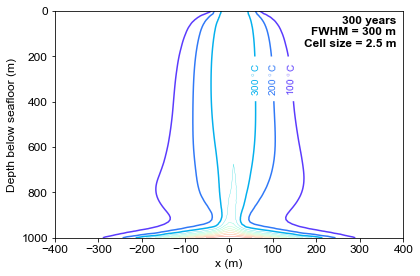

In [3]:
casePath='/Users/lruepke/Research/Lectures/HTF_lecture/Summer2022/source/lectures/L05/cases/Jupp_Schultz' # set your own path!!!
caseDir='Jupp_Schultz'
time='9460800000'
vtkfile='%s/VTK/%s_%s.vtk'%(casePath,caseDir, time)
# read result
trimesh,pointData,cellData=readVTK_2D(vtkfile)

fig=plt.figure(figsize=(6,4))
ax=plt.gca()
# ax.tricontourf(trimesh,pointData['T'],levels=50,cmap='rainbow')
ax.tricontour(trimesh,pointData['T']-273.15,levels=range(400,1200,100),cmap='rainbow',vmin=10,vmax=1200,linewidths=0.3)
levels_c=[100,200,300]
CS=ax.tricontour(trimesh,pointData['T']-273.15,levels=levels_c,cmap='rainbow',vmin=10,vmax=1200)
# specify clabel position
y_clabel=300 # approximate y of clabel
manual_locations=np.zeros((len(levels_c),2))
for i in range(0,len(CS.collections)):
    dist_min=np.zeros((len(CS.collections[i]._paths),1))
    for j in range(0,len(CS.collections[i]._paths)):
        _path=CS.collections[i]._paths[j]
        vertices_cs=_path._vertices
        dist_y=np.abs(vertices_cs[:,1]-y_clabel)
        dist_min[j]=dist_y.min()
    ind_path=np.argmin(dist_min)
    vertices_cs=CS.collections[i]._paths[ind_path]._vertices
    dist_y=np.abs(vertices_cs[:,1]-y_clabel)
    ind=np.argmin(dist_y)
    manual_locations[i,:]=vertices_cs[ind]
ax.clabel(CS, inline=True, fmt='%.0f $^{\circ}$C', fontsize=10,manual=manual_locations)

ax.set_xlim(-400,400)
ax.set_ylim(0, 1000)
ax.set_xlabel('x (m)')
ax.set_ylabel('Depth below seafloor (m)')
ax.text(0.98,0.98,'%.0f years\nFWHM = 300 m\nCell size = 10 m'%(float(time)/sec_year),fontsize=12,fontweight='bold',va='top',ha='right',transform=ax.transAxes)
ax.invert_yaxis()
plt.tight_layout()

#plt.savefig(path_figures+'/T_Jupp_Schultz300_2.5_steady.pdf')
#plt.savefig(path_figures+'/T_Jupp_Schultz300_2.5_steady.svg')

plt.show()

## Temperature + velocity field (quiver)

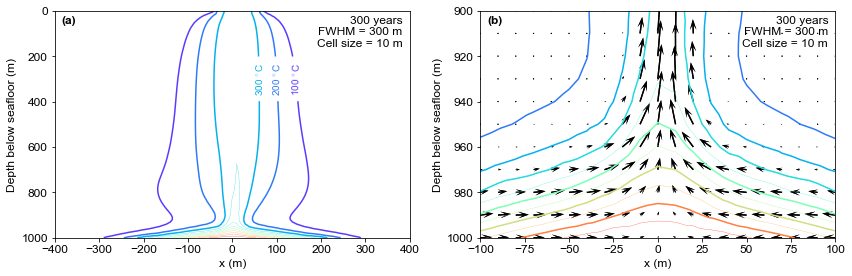

In [4]:
casePath='..'
caseDir='Jupp_Schultz'
time='9460800000' 
vtkfile='%s/VTK/%s_%s.vtk'%(casePath,caseDir, time)
# read result
trimesh,pointData,cellData=readVTK_2D(vtkfile)

fig,axs=plt.subplots(1,2,sharex=False,sharey=False,gridspec_kw={"width_ratios":[1,1],"height_ratios":[1]},
                         figsize=(12,4))
# Fig a
ax=axs[0]
# ax.tricontourf(trimesh,pointData['T'],levels=50,cmap='rainbow')
ax.tricontour(trimesh,pointData['T']-273.15,levels=range(400,1200,100),cmap='rainbow',vmin=10,vmax=1200,linewidths=0.3)
levels_c=[100,200,300]
CS=ax.tricontour(trimesh,pointData['T']-273.15,levels=levels_c,cmap='rainbow',vmin=10,vmax=1200)
# specify clabel position
y_clabel=300 # approximate y of clabel
manual_locations=np.zeros((len(levels_c),2))
for i in range(0,len(CS.collections)):
    dist_min=np.zeros((len(CS.collections[i]._paths),1))
    for j in range(0,len(CS.collections[i]._paths)):
        _path=CS.collections[i]._paths[j]
        vertices_cs=_path._vertices
        dist_y=np.abs(vertices_cs[:,1]-y_clabel)
        dist_min[j]=dist_y.min()
    ind_path=np.argmin(dist_min)
    vertices_cs=CS.collections[i]._paths[ind_path]._vertices
    dist_y=np.abs(vertices_cs[:,1]-y_clabel)
    ind=np.argmin(dist_y)
    manual_locations[i,:]=vertices_cs[ind]
ax.clabel(CS, inline=True, fmt='%.0f $^{\circ}$C', fontsize=10,manual=manual_locations)
ax.set_xlim(-400,400)
ax.set_ylim(0, 1000)
ax.set_xlabel('x (m)')
ax.set_ylabel('Depth below seafloor (m)')
ax.text(0.98,0.98,'%.0f years\nFWHM = 300 m\nCell size = 10 m'%(float(time)/sec_year),va='top',ha='right',transform=ax.transAxes)
ax.text(0.02,0.98,'(a)',fontsize=12,fontweight='bold',va='top',ha='left',transform=ax.transAxes)
ax.invert_yaxis()
plt.tight_layout()

# b
ax=axs[1]
ind2=((trimesh.x>=-100) & (trimesh.x<=100) & (trimesh.y>=900) & (trimesh.y<=1000))
ax.tricontour(trimesh.x[ind2],trimesh.y[ind2],pointData['T'][ind2]-273.15,levels=range(400,1200,100),cmap='rainbow',vmin=10,vmax=1200,linewidths=0.3)
levels_c=[200,300,400, 600, 800, 1000]
CS=ax.tricontour(trimesh.x[ind2],trimesh.y[ind2],pointData['T'][ind2]-273.15,levels=levels_c,cmap='rainbow',vmin=10,vmax=1200)
# quiver
U=pointData['U']
vx,vy=U[:,0],U[:,1]
ax.quiver(trimesh.x[ind2], trimesh.y[ind2], vx[ind2], vy[ind2], 
          units='xy', scale=1E-7,width=0.7, headwidth=5, headlength=8)

ax.set_xlim(-100,100)
ax.set_ylim(900, 1000)
ax.set_xlabel('x (m)')
ax.set_ylabel('Depth below seafloor (m)')
ax.text(0.98,0.98,'%.0f years\nFWHM = 300 m\nCell size = 10 m'%(float(time)/sec_year),va='top',ha='right',transform=ax.transAxes)
ax.text(0.02,0.98,'(b)',fontsize=12,fontweight='bold',va='top',ha='left',transform=ax.transAxes)
ax.invert_yaxis()
plt.tight_layout()

#plt.savefig(path_figures+'/T_Jupp_Schultz_steady.pdf')
#plt.savefig(path_figures+'/T_Jupp_Schultz_steady.svg')

plt.show()

## Early stage

see Fig. 2 of Juppy & Schultz (2000)

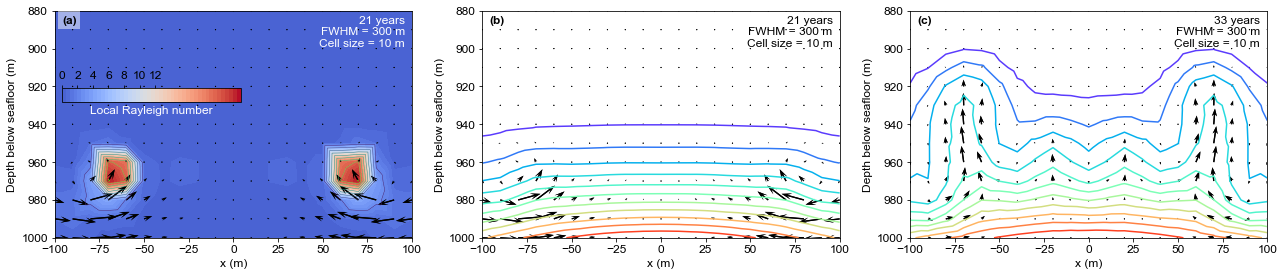

In [7]:
casePath='..'
caseDir='Jupp_Schultz'

fig,axs=plt.subplots(1,3,sharex=False,sharey=False,gridspec_kw={"width_ratios":[1,1,1],"height_ratios":[1]},
                         figsize=(18,4))
# Fig a
ax=axs[0]
# read result
time='662256000'
vtkfile='%s/VTK/%s_%s.vtk'%(casePath,caseDir, time)
trimesh,pointData,cellData=readVTK_2D(vtkfile)
ind2=((trimesh.x>=-100) & (trimesh.x<=100) & (trimesh.y>=880) & (trimesh.y<=1000))
Ral=pointData['LocalRayleigh'][ind2]
CS=ax.tricontourf(trimesh.x[ind2], trimesh.y[ind2],Ral,levels=50,cmap='coolwarm',vmin=-1)
ax.tricontour(trimesh.x[ind2], trimesh.y[ind2],Ral,levels=10,linewidths=0.5)
caxis = ax.inset_axes([0.02,0.6,0.5,0.06],transform=ax.transAxes)
cb = plt.colorbar(CS, cax=caxis, orientation='horizontal') 
cb.set_ticks(range(0,14,2))
# caxis.set_xlim(Ral.min(),Ral.max())
# caxis.xaxis.set_major_locator(MultipleLocator(3))
caxis.xaxis.set_ticks_position('top')
caxis.set_xlabel('Local Rayleigh number',color='w')
    
# quiver
U=pointData['U']
vx,vy=U[:,0],U[:,1]
ax.quiver(trimesh.x[ind2], trimesh.y[ind2], vx[ind2], vy[ind2], 
          units='xy', scale=2E-8,width=0.7, headwidth=5, headlength=8)
ax.set_xlim(-100,100)
ax.set_ylim(880, 1000)
ax.set_xlabel('x (m)')
ax.set_ylabel('Depth below seafloor (m)')
ax.text(0.98,0.98,'%.0f years\nFWHM = 300 m\nCell size = 10 m'%(float(time)/sec_year),color='w',va='top',ha='right',transform=ax.transAxes)
ax.text(0.02,0.98,'(a)',bbox={'facecolor':'w','edgecolor':'None','alpha':0.5},fontsize=12,fontweight='bold',va='top',ha='left',transform=ax.transAxes)
ax.invert_yaxis()

# Fig b
ax=axs[1]
# read result
time='662256000'
vtkfile='%s/VTK/%s_%s.vtk'%(casePath,caseDir, time)
trimesh,pointData,cellData=readVTK_2D(vtkfile)
# ax.tricontourf(trimesh,pointData['T'],levels=50,cmap='rainbow')
ax.tricontour(trimesh.x[ind2], trimesh.y[ind2],pointData['T'][ind2]-273.15,levels=range(100,1200,100),cmap='rainbow',vmin=10,vmax=1200)
# quiver
U=pointData['U']
vx,vy=U[:,0],U[:,1]
ax.quiver(trimesh.x[ind2], trimesh.y[ind2], vx[ind2], vy[ind2], 
          units='xy', scale=2E-8,width=0.7, headwidth=5, headlength=8)
ax.set_xlim(-100,100)
ax.set_ylim(880, 1000)
ax.set_xlabel('x (m)')
ax.set_ylabel('Depth below seafloor (m)')
ax.text(0.98,0.98,'%.0f years\nFWHM = 300 m\nCell size = 10 m'%(float(time)/sec_year),va='top',ha='right',transform=ax.transAxes)
ax.text(0.02,0.98,'(b)',fontsize=12,fontweight='bold',va='top',ha='left',transform=ax.transAxes)
ax.invert_yaxis()

# Fig c
ax=axs[2]
# read result
time='1040688000'
vtkfile='%s/VTK/%s_%s.vtk'%(casePath,caseDir, time)
trimesh,pointData,cellData=readVTK_2D(vtkfile)
# ax.tricontourf(trimesh,pointData['T'],levels=50,cmap='rainbow')
ax.tricontour(trimesh.x[ind2], trimesh.y[ind2],pointData['T'][ind2]-273.15,levels=range(100,1200,100),cmap='rainbow',vmin=10,vmax=1200)
# quiver
U=pointData['U']
vx,vy=U[:,0],U[:,1]
ax.quiver(trimesh.x[ind2], trimesh.y[ind2], vx[ind2], vy[ind2], 
          units='xy', scale=1E-7,width=0.7, headwidth=4, headlength=6)
ax.set_xlim(-100,100)
ax.set_ylim(880, 1000)
ax.set_xlabel('x (m)')
ax.set_ylabel('Depth below seafloor (m)')
ax.text(0.98,0.98,'%.0f years\nFWHM = 300 m\nCell size = 10 m'%(float(time)/sec_year),va='top',ha='right',transform=ax.transAxes)
ax.text(0.02,0.98,'(c)',fontsize=12,fontweight='bold',va='top',ha='left',transform=ax.transAxes)
ax.invert_yaxis()


plt.tight_layout()
#plt.savefig(path_figures+'/Jupp_Schultz_early.pdf')
#plt.savefig(path_figures+'/Jupp_Schultz_early.svg')

plt.show()